# 1. Зависимости и служебные функции

In [1]:
!pip -q install onnx onnxruntime insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.9 MB/s eta 0:00:00


In [121]:
from insightface.app import FaceAnalysis
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from typing import Optional, Tuple, List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2

import math

# Выбор устройства для обработки тензоров. Пайплайн работает и на GPU, и на CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Статистики (де)нормализации для набора ImageNet: на нем предобучена часть моделей.
imagenet_stats = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

## 1.1. Детектор лиц

Для детекции лиц на изображениях использован детектор на основе InsightFace. Работает на CPU. При объявлении экземпляра происходит подгрузка весов из внешнего источника. Возвращает список с кортежами координат "ббокса" для каждого найденного лица в формате XYXY. Не возвращает ключевые точки.

In [17]:
class SCRFDetector:
    def __init__(self, det_thresh: float = 0.5):
        self.app = FaceAnalysis(
            providers=['CPUExecutionProvider'],
            allowed_modules=['detection']
        )
        self.app.prepare(ctx_id=-1, det_size=(640, 640))
        self.app.det_model.det_thresh = det_thresh

    def __call__(self, image: np.ndarray) -> list:
        if image.ndim != 3 or image.shape[2] != 3:
            raise ValueError("Input must be RGB image with shape (H, W, 3)")

        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        faces = self.app.get(image_bgr)

        bboxes = []
        h, w = image.shape[:2]
        for face in faces:
            bbox = face['bbox']  # [x1, y1, x2, y2]
            x1, y1, x2, y2 = map(int, bbox)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            if x2 > x1 and y2 > y1:
                bboxes.append((x1, y1, x2, y2))
        return bboxes

In [316]:
# объявление детектора (при запуске подгрузит модель `buffalo_l`)
detector = SCRFDetector(det_thresh=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


## 1.2. Детектор ключевых точек

Для детекции ключевых точек (далее по тексту также "лендмарки") использована архитектура StackedHourglass. Возвращает тепловые карты для 5 лендмарков (левый и правый зрачки, кончик носа, левый и правый углы рта; стороны указаны относительно расположения изображения на мониторе, а не субъекта изображения).

In [40]:
class ResidualBlock(nn.Module):
    """Базовый residual блок из Stacked Hourglass.

    Следует архитектуре:
    conv1x1 → conv3x3 → conv1x1 + skip connection
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Skip connection: identity или 1x1 conv для согласования каналов
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)


class Hourglass(nn.Module):
    """Один модуль 'песочных часов' глубины n.

    Args:
        n: глубина рекурсии (количество уровней даунсэмпла)
        f: количество фильтров на всех уровнях
    """
    def __init__(self, n, f, residual_block):
        super().__init__()
        assert n >= 1, "Глубина hourglass должна быть >= 1"

        self.up1 = residual_block(f, f)
        self.pool = nn.MaxPool2d(2, 2)

        if n == 1:
            # Базовый случай: два residual блока на самом нижнем уровне
            self.low1 = residual_block(f, f)
            self.low2 = residual_block(f, f)
        else:
            # Рекурсивный вызов для более глубокой структуры
            self.low1 = Hourglass(n - 1, f, residual_block)

        self.low3 = residual_block(f, f)
        # Апсэмпл: nearest neighbour достаточно для этой задачи
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        up1 = self.up1(x)          # Обработка на текущем разрешении
        low1 = self.pool(x)        # Даунсэмпл
        low2 = self.low1(low1)     # Рекурсивная обработка
        low3 = self.low3(low2)     # Обработка после рекурсии
        up2 = self.up2(low3)       # Апсэмпл обратно
        return up1 + up2           # Skip connection


class StackedHourglassNetwork(nn.Module):
    """Stacked Hourglass Network для предсказания ключевых точек.

    Выход: [B, n_stacks, n_landmarks, H/4, W/4]
    где H, W — размер входного изображения.
    """
    def __init__(self, n_stacks=2, n_modules=4, n_landmarks=5, in_channels=3):
        super().__init__()
        self.n_stacks = n_stacks
        self.n_landmarks = n_landmarks

        # Начальный блок: уменьшает разрешение до H/4, W/4 (от 256х256 к 64х64)
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),  # /2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),  # /2 → итого /4
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )

        # Инициализация стеков
        hg_modules, res_modules, fc_modules, score_modules = [], [], [], []
        for i in range(n_stacks):
            hg_modules.append(Hourglass(n_modules, 256, ResidualBlock))
            res_modules.append(ResidualBlock(256, 256))
            fc_modules.append(nn.Sequential(
                nn.Conv2d(256, 256, 1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ))
            score_modules.append(nn.Conv2d(256, n_landmarks, 1))

        self.hg = nn.ModuleList(hg_modules)
        self.res = nn.ModuleList(res_modules)
        self.fc = nn.ModuleList(fc_modules)
        self.score = nn.ModuleList(score_modules)

        # Модули для промежуточной обратной связи (intermediate supervision; между стеками)
        self.fc_ = nn.ModuleList([nn.Conv2d(256, 256, 1) for _ in range(n_stacks - 1)])
        self.score_ = nn.ModuleList([nn.Conv2d(n_landmarks, 256, 1) for _ in range(n_stacks - 1)])

    def forward(self, x):
        x = self.pre(x)  # [B, 256, H/4, W/4]
        combined_hm_preds = []

        for i in range(self.n_stacks):
            hg = self.hg[i](x)
            hg = self.res[i](hg)
            hg = self.fc[i](hg)
            score = self.score[i](hg)
            combined_hm_preds.append(score)

            # Промежуточная обратная связь (кроме последнего стека)
            if i < self.n_stacks - 1:
                x = x + self.fc_[i](hg) + self.score_[i](score)

        return torch.stack(combined_hm_preds, dim=1)  # [B, n_stacks, n_landmarks, H/4, W/4]


def load_lm_detector(checkpoint_path='lm_detection_model.pth',
                     model_class=StackedHourglassNetwork,
                     device=device,
                     **model_kwargs):
    """
    Загружает лучшую модель из чекпоинта.

    Args:
        checkpoint_path: путь к файлу чекпоинта
        model_class: класс модели (по умолчанию, StackedHourglassNetwork)
        device: устройство ('cuda' или 'cpu')
        **model_kwargs: аргументы для инициализации модели (n_stacks, n_modules, etc.)

    Returns:
        model: модель с загруженными весами
        history: история обучения (если сохранена)
    """
    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Инициализируем модель
    model = model_class(**model_kwargs).to(device)

    # Загружаем веса
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Получаем историю (если есть)
    history = checkpoint.get('history', None)

    # В инференсе не используется
    # print(f"Лучшая модель загружена! Epoch: {checkpoint['epoch'] + 1}")
    # print(f"Val NME: {min(checkpoint['history']['val_nme']):.4f}%")

    return model, history

In [39]:
# загрузка весов модели для детекции лендмарков
!gdown -q 1RQyIhEkl8oe67E98Zk3i0gymUbZb3Voi

# создание модели и загрузка в нее весов.
# Единственная доступная конфигурация на данный момент: n_stacks=2,  n_modules=4, n_landmarks=5.
landmark_detector, _ = load_lm_detector()

# удаление файла с весами
!rm lm_detection_model.pth

In [106]:
def resize_with_pad(image, target_size=256, mirror=False):
    """
    Ресайзит изображение до максимальной вписываемой области в target_size×target_size,
    добавляет паддинг (зеркальный или константный).

    Args:
        image: np.ndarray [H, W, C]
        target_size: int
        mirror: bool

    Возвращает:
        resized_image: [target_size, target_size, C]
    """
    h, w = image.shape[:2]

    # Масштаб для вписывания
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Ресайз
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Паддинг до квадрата
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    pad_top = pad_h // 2
    pad_left = pad_w // 2

    border_padding = dict(borderType=cv2.BORDER_CONSTANT,
                          value=(127, 127, 127))
    if mirror:
        border_padding = dict(borderType=cv2.BORDER_REFLECT_101)

    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_h - pad_top, pad_left, pad_w - pad_left,
        **border_padding
        )

    return padded

def resize_with_pad_and_update_landmarks(image, landmarks, target_size=256, mirror=False):
    """
    Ресайзит изображение до максимальной вписываемой области в target_size×target_size,
    добавляет паддинг (зеркальный или константный), обновляет координаты лендмарков.

    Args:
        image: np.ndarray [H, W, C]
        landmarks: list of (x, y)
        target_size: int
        mirror: bool - если True, то зеркальный паддинг; иначе - константный серый (127, 127, 127)

    Возвращает:
        resized_image: [target_size, target_size, C]
        new_landmarks: list of (x, y) в пересчитанных координатах
    """
    h, w = image.shape[:2]

    # Масштаб для вписывания
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Ресайз
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Обновляем лендмарки
    new_landmarks = [(x * scale, y * scale) for (x, y) in landmarks]

    # Паддинг до квадрата
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    pad_top = pad_h // 2
    pad_left = pad_w // 2

    border_padding = dict(borderType=cv2.BORDER_CONSTANT,
                          value=(127, 127, 127))
    if mirror:
        border_padding = dict(borderType=cv2.BORDER_REFLECT_101)

    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_h - pad_top, pad_left, pad_w - pad_left,
        **border_padding
        )

    # Сдвигаем лендмарки из-за паддинга
    new_landmarks = [(x + pad_left, y + pad_top) for (x, y) in new_landmarks]

    return padded, new_landmarks


def heatmaps_to_landmarks(heatmaps):
    """
    Преобразует тепловые карты в координаты ключевых точек.

    Args:
        heatmaps: torch.Tensor [B, 5, H, W]

    Возвращает:
        landmarks: torch.Tensor [B, 5, 2] в формате (x, y)
    """
    B, N, H, W = heatmaps.shape

    # Находим argmax по пространственным измерениям
    heatmaps_flat = heatmaps.view(B, N, -1)  # [B, N, H*W]
    max_indices = heatmaps_flat.argmax(dim=2)  # [B, N]

    # Преобразуем линейные индексы в (y, x)
    y_coords = max_indices // W
    x_coords = max_indices % W

    # Собираем в тензор [B, 5, 2]
    landmarks = torch.stack([x_coords, y_coords], dim=2).float()  # (x, y)

    return landmarks


def predict_landmarks(image, model=landmark_detector, device=device, resize=False, target_size=256):
    """
    Предсказывает лендмарки лица на изображении произвольного размера (выравнивание не требуется).

    Args:
        model: обученная модель StackedHourglassNetwork
        image: np.ndarray [H, W, C] - исходное изображение в BGR или RGB
        device: устройство для inference ('cuda' или 'cpu')
        resize: bool - если True, возвращает преобразованное изображение 256x256 и лендмарки для него;
                если False, возвращает только лендмарки для исходного изображения
        target_size: int - целевой размер для нормализации (по умолчанию 256)

    Возвращает:
        Если resize=True: (resized_image, landmarks_256)
            resized_image: np.ndarray [256, 256, C]
            landmarks_256: np.ndarray [5, 2] - координаты в системе координат 256x256

        Если resize=False: landmarks_original
            landmarks_original: np.ndarray [5, 2] - координаты в системе координат исходного изображения
    """
    model.eval()

    # Сохраняем исходные размеры
    orig_h, orig_w = image.shape[:2]

    # Создаем фиктивные лендмарки для использования resize_with_pad_and_update_landmarks
    dummy_landmarks = [(0, 0)] * 5

    # Преобразуем изображение к 256x256 с паддингом
    resized_image, _ = resize_with_pad_and_update_landmarks(
        image, dummy_landmarks, target_size
    )

    # Конвертируем в тензор
    if len(resized_image.shape) == 3:
        image_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float()  # [C, H, W]
    else:
        image_tensor = torch.from_numpy(resized_image).unsqueeze(0).float()  # [1, H, W]

    # Добавляем batch dimension и переносим на устройство
    image_batch = image_tensor.unsqueeze(0).to(device)  # [1, C, 256, 256]

    with torch.no_grad():
        # Получаем предсказание
        outputs = model(image_batch)  # [1, S, 5, 64, 64]
        pred_heatmaps = outputs[0, -1]  # [5, 64, 64]

        # Преобразуем тепловые карты в координаты (64x64)
        pred_landmarks_64 = heatmaps_to_landmarks(pred_heatmaps.unsqueeze(0))[0]  # [5, 2]

        # Масштабируем к 256x256
        pred_landmarks_256 = pred_landmarks_64 * 4.0  # [5, 2]

    # Конвертируем в numpy
    landmarks_256_np = pred_landmarks_256.cpu().numpy()

    if resize:
        # Возвращаем преобразованное изображение и лендмарки для 256x256
        return resized_image.astype(np.uint8), landmarks_256_np
    else:
        # Обратное преобразование координат в исходную систему координат

        # 1. Убираем паддинг из координат
        scale = target_size / max(orig_h, orig_w)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)
        pad_h = target_size - new_h
        pad_w = target_size - new_w
        pad_top = pad_h // 2
        pad_left = pad_w // 2

        landmarks_no_pad = landmarks_256_np - [pad_left, pad_top]

        # 2. Обратное масштабирование к исходному размеру
        landmarks_original = landmarks_no_pad / scale

        return landmarks_original


def predict_landmarks_batch(
    images: list,
    model=landmark_detector,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    target_size=256
) -> np.ndarray:
    """
    Предсказывает лендмарки для списка подготовленных изображений (уже 256x256 с паддингом).

    Args:
        images: список np.ndarray [H, W, C]
        model: обученная модель StackedHourglassNetwork
        device: устройство для inference
        target_size: размер изображений (должен быть 256)

    Returns:
        landmarks_batch: np.ndarray [B, 5, 2] - координаты лендмарков в системе координат 256x256
    """
    model.eval()

    # Проверка входных данных
    assert len(images) > 0, "Список изображений пуст"
    assert all(img.shape == (target_size, target_size, 3) for img in images), \
        f"Все изображения должны быть размером ({target_size}, {target_size}, 3)"

    # Конвертация списка изображений в тензор
    image_tensors = []
    for img in images:
        # Конвертируем в тензор [C, H, W]
        if len(img.shape) == 3:
            tensor = torch.from_numpy(img).permute(2, 0, 1).float()  # [C, H, W]
        else:
            tensor = torch.from_numpy(img).unsqueeze(0).float()  # [1, H, W]
        image_tensors.append(tensor)

    # Объединяем в батч [B, C, H, W]
    batch_tensor = torch.stack(image_tensors, dim=0).to(device)

    with torch.no_grad():
        # Получаем предсказания для всего батча
        outputs = model(batch_tensor)  # [B, S, 5, 64, 64]
        pred_heatmaps = outputs[:, -1]  # [B, 5, 64, 64]

        # Преобразуем тепловые карты в координаты (64x64)
        pred_landmarks_64 = heatmaps_to_landmarks(pred_heatmaps)  # [B, 5, 2]

        # Масштабируем к 256x256
        pred_landmarks_256 = pred_landmarks_64 * 4.0  # [B, 5, 2]

    # Конвертируем в numpy
    return pred_landmarks_256.cpu().numpy()

## 1.3. Эмбеддинг-модель

Модель для построения эмбеддингов основана на архитектуре ResNet18 (backbone) и ArcFace (в инференс-версии слой ArcFace исключен). Возвращает эмбеддинг-вектор размерности 512 для каждого изображения (размерность по выходу AvgPool-слоя ResNet18). На вход принимает изображения 256*256 после выравнивания по лендмаркам (афинное преобразование: выравнивание по линии глаз с центрированием вокруг носа)

In [112]:
class ArcFaceLayer(nn.Module):
    """
    ArcFace слой для обучения и валидации.
    Используется как замена последнему Linear-слою в классификации.
    """
    def __init__(self, in_features, out_features, s=32.0, m=0.2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        # Веса классов (нормализуются в forward)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels=None):
        """
        Args:
            embeddings: [B, in_features] — эмбеддинги из backbone'а
            labels: [B] — метки классов (обязательны при обучении, опциональны при валидации)

        Returns:
            logits: [B, out_features] — модифицированные логиты для CrossEntropy
        """
        # Нормализация
        embeddings = F.normalize(embeddings, dim=1)  # [B, D]
        weight = F.normalize(self.weight, dim=1)     # [C, D]

        # Косинусы между всеми парами и клиппинг
        cos_theta = F.linear(embeddings, weight)
        cos_theta = cos_theta.clamp(-1.0, 1.0)

        # При валидации -- обычные косинусы без маржина
        if labels is None:
            return self.s * cos_theta

        with torch.no_grad():
            # Извлекаем cos для целевых классов
            cos_target = cos_theta[range(len(labels)), labels]  # [B]
            # Вычисляем theta и модифицируем
            theta = torch.acos(cos_target)
            cos_theta_target = torch.cos(theta + self.m)  # [B]
            # Создаём дельту для замены
            delta = cos_theta_target - cos_target  # [B]
            # Расширяем до [B, C]
            delta = delta.unsqueeze(1).expand_as(cos_theta)
            # Создаём маску для целевых классов
            mask = torch.zeros_like(cos_theta)
            mask[range(len(labels)), labels] = 1.0

        # Применяем модификацию к целевым классам
        cos_theta_final = cos_theta + delta * mask
        logits = self.s * cos_theta_final
        return logits


def create_arcface_model(
    num_classes: int,
    embedding_size: int = 256,
    pretrained: bool = True,
    s: float = 30.0,
    m: float = 0.5
) -> nn.Module:
    """
    Вместо классификатора при обучении использован ArcFace-слой.
    """
    from torchvision.models import resnet18, ResNet18_Weights

    if pretrained:
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)
    else:
        model = resnet18()

    # Берем все до avgpool, выход с avgpool принимаем за эмбеддинг
    backbone = nn.Sequential(
        model.conv1, model.bn1, model.relu, model.maxpool,
        model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool
    )

    # Работаем напрямую с выходом avgpool (512) как экстрактором
    arcface_layer = ArcFaceLayer(512, num_classes, s=s, m=m)

    class ArcFaceModel(nn.Module):
        def __init__(self, backbone, arcface_layer):
            super().__init__()
            self.backbone = backbone
            self.arcface_layer = arcface_layer

        def forward(self, x, labels=None, return_embeddings=False):
            """
            Args:
                x: входные изображения [B, 3, H, W]
                labels: метки классов (для обучения)
                return_embeddings: вернуть эмбеддинги вместо логитов

            Возвращает:
                логиты (для обучения) либо эмбеддинги (для инференса)
            """
            features = self.backbone(x)
            embeddings = torch.flatten(features, 1)  # [B, 512]

            if return_embeddings:
                return F.normalize(embeddings, p=2, dim=1)

            # Для валидации: labels=None => обычные косинусы
            # Для обучения: labels != None => ArcFace с маржином
            logits = self.arcface_layer(embeddings, labels)
            return logits

    return ArcFaceModel(backbone, arcface_layer)

In [313]:
def load_arcface_model_for_inference(
    checkpoint_path: str = 'face_embedding_model.pth',
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> nn.Module:
    """
    Загружает только backbone модели для извлечения эмбеддингов.
    ArcFace-слой отбрасывается.
    """
    # print(f"Загрузка backbone из чекпоинта: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Создаем "чистую" модель только с backbone
    class InferenceModel(nn.Module):
        def __init__(self, state_dict):
            super().__init__()
            # Восстанавливаем backbone из state_dict
            from torchvision.models import resnet18, ResNet18_Weights
            model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            self.backbone = nn.Sequential(
                model.conv1, model.bn1, model.relu, model.maxpool,
                model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool
            )
            # Загружаем веса backbone
            backbone_state = {k.replace('backbone.', ''): v
                            for k, v in checkpoint['model_state_dict'].items()
                            if k.startswith('backbone.')}
            self.backbone.load_state_dict(backbone_state)

        def forward(self, x):
            features = self.backbone(x)
            embeddings = torch.flatten(features, 1)
            return F.normalize(embeddings, p=2, dim=1)

    model = InferenceModel(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

In [314]:
# загрузка весов
!gdown -q 1L03l0xK10sHChe42NKfMkLG4dgn7Qx7X

# загрузка модели (для инференса, т.е. только ResNet18-backbone, без arcface-слоя)
face_vectorizer = load_arcface_model_for_inference()

# удаление весов
!rm face_embedding_model.pth

In [224]:
def align_face_after_resize(image_256, landmarks_256, output_size=256, mirror=False):
    """
    Выполняет аффинное выравнивание на изображении 256×256 по соответствующим лендмаркам.
    Выравнивает по линии глаз, центрирует по кончику носа.
    Возвращает преобразованное изображение с паддингом. Паддинг: зеркальный или константный;
    по умолчанию, константный серый: (127, 127, 127).
    """
    le_x, le_y = landmarks_256[0]
    re_x, re_y = landmarks_256[1]
    nose_x, nose_y = landmarks_256[2]

    angle = np.degrees(np.arctan2(re_y - le_y, re_x - le_x))
    M = cv2.getRotationMatrix2D((nose_x, nose_y), angle, 1.0)
    M[0, 2] += output_size // 2 - nose_x
    M[1, 2] += output_size // 2 - nose_y


    border_padding = dict(borderMode=cv2.BORDER_CONSTANT,
                          borderValue=(127, 127, 127))
    if mirror:
        border_padding = dict(borderMode=cv2.BORDER_REFLECT_101)

    return cv2.warpAffine(
        image_256, M, (output_size, output_size),
        flags=cv2.INTER_LINEAR,
        **border_padding
    )

def preprocess_image(image):
    """
    Предобработка изображения перед подачей на вычисление эмбеддинга.
    Включает в себя нормализацию по статистикам ImageNet.
    Возвращает тензор 224*224.
    """

    transform = v2.Compose([
        v2.Resize((224, 224)), # под ResNet18
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(**imagenet_stats) # модель была предобучена на ImageNet
    ])
    return transform(image)

def get_embedding(image, model=face_vectorizer):
    """
    Вычисляет эмбеддинг для изображения.
    Возвращает тензор размерности [1, 512] на CPU.
    Модель по умолчанию -- `face_vectorizer`.
    """
    image_tensor = preprocess_image(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        embedding = model(image_tensor)
    return embedding.cpu()

def get_embeddings(images, model=face_vectorizer):
    """
    Вычисляет эмбеддинги для батча изображений из iterable-объекта.
    Возвращает тензор размерности [B, 512] на CPU.
    Модель по умолчанию -- `face_vectorizer`.
    """
    image_tensor = torch.stack(
        [preprocess_image(image) for image in images],
        dim=0).to(device)
    model.eval()
    with torch.no_grad():
        embeddings = model(image_tensor)
    return embeddings.cpu()

def compare_embeddings(emb_1, emb_2) -> float:
    """
    Вычисляет косинусное сходство между двумя тензорами эмбеддингов
    (здесь: [1, 512]) для выровненных лиц.
    Границы:
      - 0.000-0.499 -- разные люди (сильная уверенность)
      - 0.500-0.599 -- разные люди (достаточная уверенность)
      - 0.600-0.649 -- граничная зона
      - 0.650-0.749 -- один и тот же человек (достаточная уверенность)
      - 0.749-0.999 -- один и тот же человек (сильная уверенность)
    Возвращает значение косинусного сходства (float).
    """
    cos_sim = torch.cosine_similarity(emb_1, emb_2).clamp(1e-7, 1 - 1e-7).item()
    result = ''
    if cos_sim < .500:
        result = f'different (++)'
    elif cos_sim < .600:
        result = f'different (+)'
    elif cos_sim < .650:
        result = f'not sure (+-)'
    elif cos_sim < .700:
        result = f'same (+)'
    else:
        result = f'same (++)'
    return cos_sim, result

def compare_images(image_1, image_2, model=face_vectorizer):
    """
    Вычисляет косинусное сходство между двумя выровненными лицами по вычисленным эмбеддингам.
    Возвращает значение косинусного сходства (float).
    """
    emb_1 = get_embedding(image_1, model)
    emb_2 = get_embedding(image_2, model)
    cos_sim, result = compare_embeddings(emb_1, emb_2)
    return cos_sim, result

## 1.4. Дополнительные функции для демонстрации работы пайплайна

In [304]:
# Поскольку cv2 использует по умолчанию цветовую схему BGR, необходимо привести изображение к схеме RGB.
#   Использование BGR-схемы может негативно сказаться на работе пайплайна, т.к. модель распознавания лиц
#   обучена на изображениях со схемой RGB.

def read_image(image_path):
    """
    Читает изображение по пути средствами OpenCV и приводит к цветовой схеме RGB.
    Возвращает NumPy-массив изображения.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def draw_image(image, title=''):
    """
    Принимает изображение в формате [h, w, c] и отрисовывает средствами matplotlib.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.title(title)
    plt.show()

def get_faces(image, bboxes):
    """
    Принимает изображение в формате [h, w, c] и список ббоксов, отрисовывает средствами matplotlib.
    Возвращает массив для нового изображения и список массивов лиц, вырезанных по ббоксам,
    в порядке их нахождения детектором (+ ресайз с паддингом для сохранения пропорций).
    """

    image_bboxes = image.copy()
    found_faces = []

    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        image_ = image[y1:y2, x1:x2]
        found_faces.append(resize_with_pad(image_))
        image_bboxes = cv2.rectangle(image_bboxes, (x1, y1), (x2, y2), (0, 255, 0), thickness=3)

    return image_bboxes, found_faces

def draw_faces(faces, titles=[]):
    """
    Принимает на вход изображения в виде массивов, отрисовывает сеткой.
    Также (опционально) принимает названия для изображений в виде списка.
    """
    n = len(faces)
    ncols = max(5, math.ceil(n ** .5))
    nrows = math.ceil(n / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2, n // ncols * 2))
    ax = ax.flatten()

    for i, face in enumerate(faces):
        ax[i].imshow(face)
        ax[i].axis('off')
        if titles:
            title = titles[i]
            color = 'green' if 'same' in title else 'red'
            ax[i].set_title(title, color=color)

    for i in range(n, ncols * nrows):
        ax[i].axis('off')

    fig.tight_layout()
    fig.show()

def draw_face_with_landmarks(image, landmarks, figsize=(8, 5), s=50):
    """
    Принимает на вход изображение и список лендмарков для него,
    отрисовывает в один ряд исходное изображение и изображение с лендмарками.
    """
    landmarks = np.array(landmarks)
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=s)
    plt.title('Image with landmarks')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def get_face_with_landmarks(image, landmarks, s=5):
    """
    Принимает на вход изображение и список лендмарков для него,
    возвращает изображение с лендмарками как массив.
    """
    landmarks = np.array(landmarks)
    image_lm = image.copy()

    for landmark in landmarks:
        x, y = map(int, landmark)
        image_lm = cv2.circle(image_lm, (x, y), 1, (255, 0, 0), thickness=s)

    return image_lm

# 2. Инференс

## 2.1. Загрузка изображения

В целях демонстрации загружено изображение с персонального сайта фотографа Николая Покровского (https://nikfoto.ru). Изображение представляет собой групповой фотопортрет в деловом стиле (раздел сайта: https://nikfoto.ru/blog/shooting-a-group-portrait).

Изображение используется исключительно для демонстрации работы пайплайна как находящееся в открытом доступе и подходящее для целей демонстрации. Изображение используется в некоммерческих целях, все права принадлежат соответствующим правообладателям.

In [6]:
!wget https://nikfoto.ru/assets/cache_image/files/images/2023/IMG_7842_1920x0_215.webp

--2026-02-07 10:30:54--  https://nikfoto.ru/assets/cache_image/files/images/2023/IMG_7842_1920x0_215.webp
Resolving nikfoto.ru (nikfoto.ru)... 94.26.255.31
Connecting to nikfoto.ru (nikfoto.ru)|94.26.255.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 537456 (525K) [image/webp]
Saving to: ‘IMG_7842_1920x0_215.webp’

IMG_7842_1920x0_215 100%[===================>] 524.86K  3.29MB/s    in 0.2s    

2026-02-07 10:30:54 (3.29 MB/s) - ‘IMG_7842_1920x0_215.webp’ saved [537456/537456]



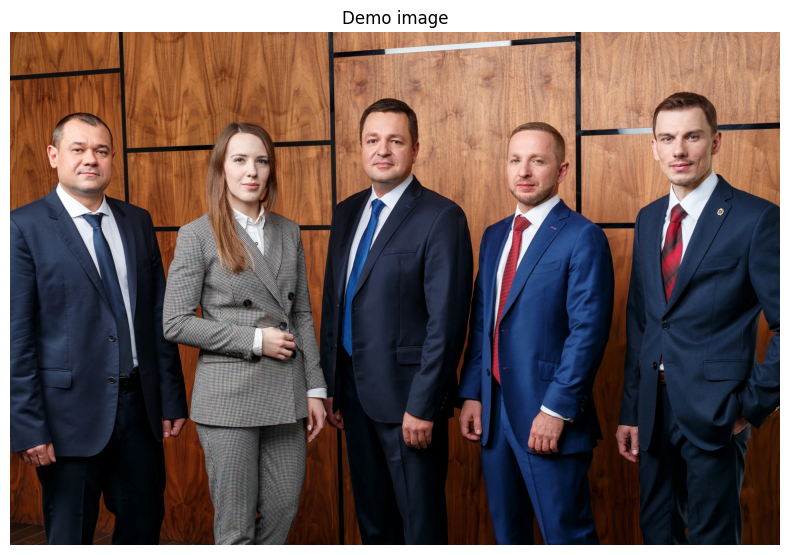

In [45]:
image_path = 'IMG_7842_1920x0_215.webp' # укажите путь к изображению

# чтение изображения
image = read_image(image_path)

# вывод демонстрационного изображения
draw_image(image, title='Demo image')

## 2.2. Детекция лиц на изображении и их извлечение

Найдено лиц: 5


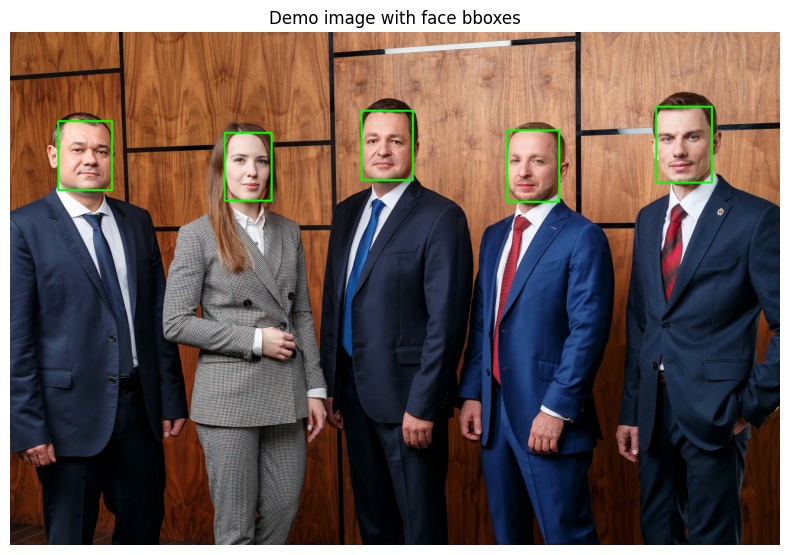

In [51]:
bboxes = detector(image)
print(f"Найдено лиц: {len(bboxes)}")

# получить изображение с отрисованными ббоксами и список массивов лиц, вырезанных по их координатам
image_bboxes, faces = get_faces(image, bboxes)

# отрисовать изображение с ббоксами лиц
draw_image(image_bboxes, title='Demo image with face bboxes')

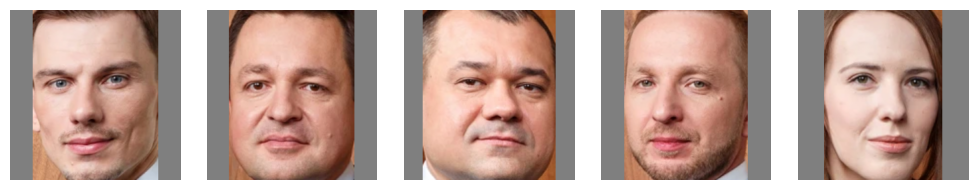

In [101]:
# отрисовать все найденные лица (с ресайзом и паддингом)
draw_faces(faces)

## 2.3. Предсказание ключевых точек (лендмарков) для всех лиц

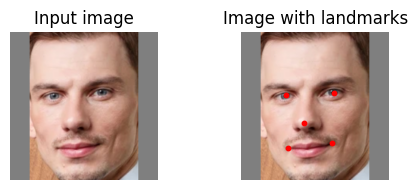

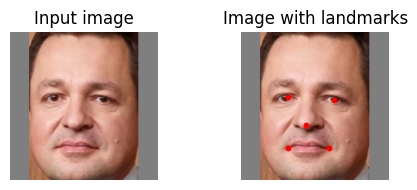

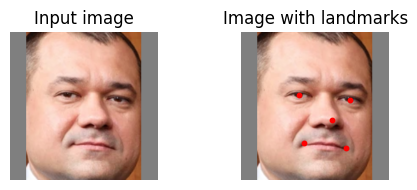

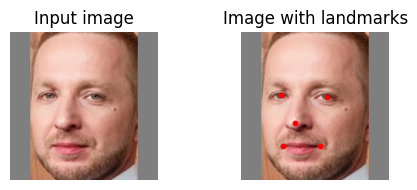

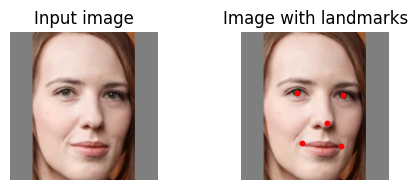

In [94]:
# предсказать лендмарки для всех лиц (пакетная обработка)
predicted_landmarks = predict_landmarks_batch(faces)

# отрисовать лица с лендмарками
for face, landmarks in zip(faces, predicted_landmarks):
    draw_face_with_landmarks(face, landmarks, figsize=(5, 2), s=10)

## 2.4. Выравнивание лиц по предсказанным ключевым точкам

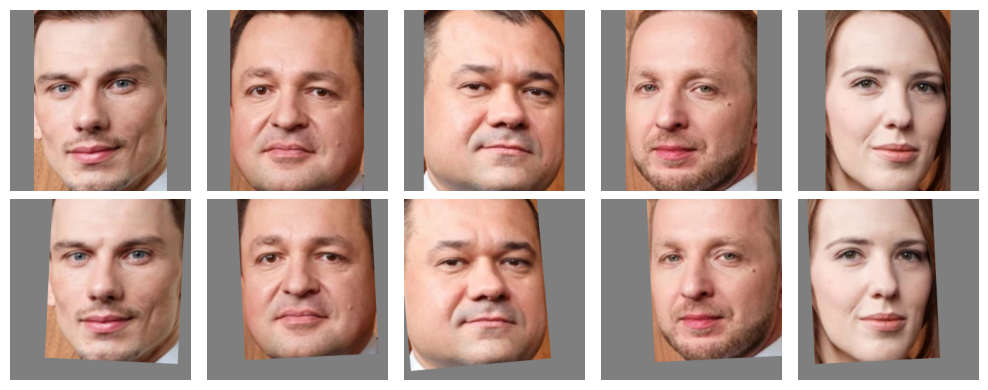

In [172]:
# выравнивание лиц по лендмаркам (афинное преобразование: центрирование вокруг носа,
# выравнивание глаз по горизонтальной линии)
aligned_faces = [align_face_after_resize(face, landmarks) for face, landmarks in zip(faces, predicted_landmarks)]

# отрисовка:
#  верхний ряд = исходные изображения
#  нижний ряд = выровненные изображения
draw_faces(faces + aligned_faces)

## 2.5. Сравнение лиц по эмбеддинг-векторам

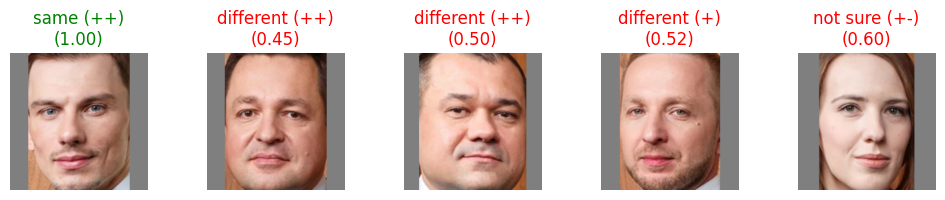

In [229]:
# выберем первое лицо как референтное
ref_face = aligned_faces[0]
results = []

# и попарно сравним его с остальными по косинусному сходству
for i, face in enumerate(aligned_faces, start=1):
    cos_sim, result = compare_images(ref_face, face)
    results.append(f'{result}\n({cos_sim:.2f})')

# выведем результаты ("+" отражает степень уверенности)
draw_faces(faces, results)

## 2.6. Сравнение лиц на разных фотографиях одного и того же человека

В целях демонстрации использованы фото Киану Ривза (Keanu Reeves) с сайта "Интересные факты" (URL: https://interesnyefakty.org/foto-kianu-rivz/). Использование носит некоммерческий характер, все права принадлежат соответствующим правообладателям.

In [272]:
# загрузка 5 фотографий
!wget -q https://interesnyefakty.org/wp-content/uploads/Foto-Kiana-Rivz.jpg
!wget -q https://interesnyefakty.org/wp-content/uploads/Akter-Kianu-Rivz.jpg
!wget -q https://interesnyefakty.org/wp-content/uploads/Foto-Kianu-Rivz-2.jpg
!wget -q https://interesnyefakty.org/wp-content/uploads/Foto-Kianu-Rivz-5.jpg
!wget -q https://interesnyefakty.org/wp-content/uploads/Foto-Kianu-Rivz-8.jpg

# сохранение изображений
images_new = [read_image(img_path) for img_path in (
    'Foto-Kiana-Rivz.jpg',
    'Akter-Kianu-Rivz.jpg',
    'Foto-Kianu-Rivz-2.jpg',
    'Foto-Kianu-Rivz-5.jpg',
    'Foto-Kianu-Rivz-8.jpg'
    )]

# удаление файлов
!rm Foto-Kiana-Rivz.jpg
!rm Akter-Kianu-Rivz.jpg
!rm Foto-Kianu-Rivz-2.jpg
!rm Foto-Kianu-Rivz-5.jpg
!rm Foto-Kianu-Rivz-8.jpg

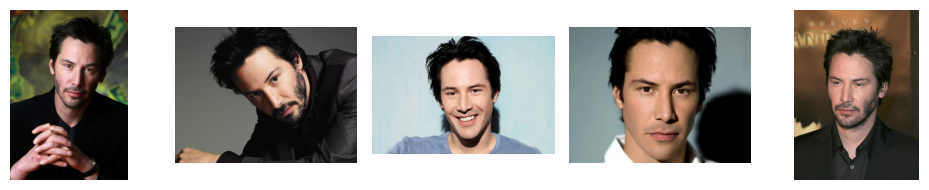

In [273]:
draw_faces(images_new)

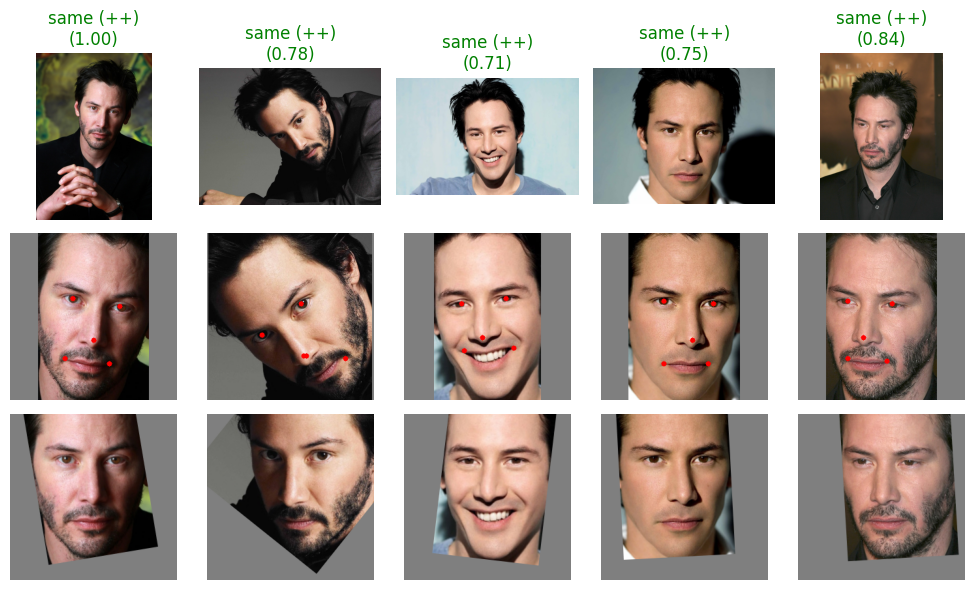

In [315]:
# рассчитать координаты ббоксов для лиц
bboxes_new = [detector(img) for img in images_new]

# извлечь список лиц по координатам из каждого изображения
faces_new = [get_faces(img, bbox)[1] for img, bbox in zip(images_new, bboxes_new)]

# в каждом списке только одно лицо (первый/нулевой элемент списка)
faces_new = [face[0] for face in faces_new]

# предсказать лендмарки для всех лиц (пакетная обработка)
predicted_landmarks_new = predict_landmarks_batch(faces_new)

# дополнительно отрисовать предсказанные лендмарки для всех лиц
faces_with_lm_new = [get_face_with_landmarks(face, landmarks) for face, landmarks in zip(faces_new, predicted_landmarks_new)]

# выровнять на основе лендмарков (по глазам и носу)
aligned_faces_new = [align_face_after_resize(face, landmarks) for face, landmarks in zip(faces_new, predicted_landmarks_new)]


### отрисовка ###
# выберем первое лицо как референтное
ref_face_new = aligned_faces_new[0]
results_new = []

# и попарно сравним его с остальными по косинусному сходству
for i, face_new in enumerate(aligned_faces_new, start=1):
    cos_sim, result = compare_images(ref_face_new, face_new)
    results_new.append(f'{result}\n({cos_sim:.2f})')

# выведем результаты ("+" отражает степень уверенности)
# три ряда:
#  1 - исходные изображения
#  2 - изображения после ресайза с предсказанными лендмарками
#  3 - изображения после выравнивания
# итоговые оценки сходства между эмбеддингами вынесены в подписи к верхнему ряду
draw_faces(images_new + faces_with_lm_new + aligned_faces_new,
           results_new + ['' for _ in range(len(images_new) * 2)]
           )

Результаты:
1. Модель InsightFace уверенно находит на изображениях лица.
2. Модель StackedHourglass преимущественно уверенно находит ключевые точки  (nme = 3,07), но при низком качестве изображения, паттерне теней и/или лицевой растительности может ошибаться с определением углов рта (см., напр., второе по порядку изображение Киану Ривза выше: детектор не нашел левый угол рта, совместив данный лендмарк с носом).
3. Модель ResNet18 (обученная с ArcFace-слоем) преимущественно уверенно определяет, одному или разным объектам принадлежат лица на изображениях. Серая зона -- 0,6-0,65.